# (22) ROI – Create figs, document everything

**Motivation**: Bring together all the things related to ROIs. <br>

In [1]:
# HIDE CODE


import os, sys
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def coronal():
    slices = range(1, 81, 4)

    ncols = 5
    nrows = int(np.ceil(len(slices) / ncols))
    fig, axes = create_figure(nrows, ncols, (ncols * 2.5, nrows * 2), 'all', 'all', constrained_layout=True)
    for i, s_ in enumerate(slices):
        ax = axes.flat[i]
        ax.annotate(
            text=s_,
            xy=(0.01, 0.9),
            xycoords='axes fraction',
            color='cyan',
        )
        ax.imshow(reg.in_house[s_], cmap='Greys_r')
        ax.imshow(mwh(obj[s_] == 0, obj[s_]), alpha=0.8, vmin=1.5, vmax=3.5, cmap='Spectral_r')
    remove_ticks(axes, False)
    plt.show()
    return fig, axes


def coronal_allen():
    slices = range(1, 528, 27)

    ncols = 5
    nrows = int(np.ceil(len(slices) / ncols))
    fig, axes = create_figure(nrows, ncols, (ncols * 2.6, nrows * 1.9), 'all', 'all', constrained_layout=True)
    for i, s_ in enumerate(slices):
        ax = axes.flat[i]
        ax.annotate(
            text=s_,
            xy=(0.01, 0.9),
            xycoords='axes fraction',
            color='cyan',
        )
        ax.imshow(mice.al.template[s_], cmap='Greys_r')
        ax.imshow(mwh(mask[s_] == 0, mask[s_]), alpha=0.8, vmin=1.5, vmax=3.5, cmap='Spectral_r')
    remove_ticks(axes, False)
    plt.show()
    return fig, axes

    
def _apply():
    obj = ants.apply_transforms(
        fixed=affined,
        moving=reg.img_in_ccf(mask),
        transformlist=tx['invtransforms'],
        interpolator='genericLabel',
    )
    obj = tx_aff_inv.apply_to_image(
        image=obj,
        reference=reg.in_house,
        interpolation='multilabel',
    )
    obj = obj.numpy()
    for i_new, i in enumerate(np.unique(obj[obj.nonzero()])):
        obj[obj == i] = i_new + 1
    return obj

## Prepare

In [3]:
from register.register import Register, reset_ants_img

mice = Mice(Config(128, resolution=25), load_parcel=True, load_allen=True)

reg = Register(mice)
reg.mi_base = ants.image_mutual_information(
    image1=reg.template, image2=reg.template)

reg.in_house

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (81, 46, 60)
         Spacing    : (200.0, 200.0, 200.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [4]:
mice.al

╭──────────────────────────────────────────────────────────────────╮
│                         Allen mouse 25um                         │
│                                                                  │
│         name:  allen_mouse (v1.2)                                │
│      species:  Mus musculus                                      │
│     citation:  Wang et al 2020                                   │
│                https://doi.org/10.1016/j.cell.2020.04.007        │
│         link:  http://www.brain-map.org                          │
│                                                                  │
│  orientation:  asr                                               │
│    symmetric:  True                                              │
│   resolution:  [25.0, 25.0, 25.0]                                │
│        shape:  [528, 320, 456]                                   │
╰──────────────────────────────────────────────────────────────────╯

## Verify scores

In [5]:
tx_fwd, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)
tx_inv, _ = reg.load_tx(reg.in_house_name, is_inv=True)
tx = {'fwdtransforms': tx_fwd, 'invtransforms': tx_inv}
tx_aff_inv = tx_aff.invert()

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)
mask.shape

(528, 320, 456)

In [6]:
scores, misc, warped = reg.tx_peformance(
    fixed=reg.template,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
)
scores

{
    'mi': 0.551089256337447,
    'ovp_MOp': 1.0,
    'sym_MOp': 1.0,
    'ovp_MOs': 1.0,
    'sym_MOs': 0.9939117199391172,
    'ovp_SS': 1.0,
    'sym_SS': 0.9986366734832992,
    'ovp_VISC': 1.0,
    'sym_VISC': 1.0,
    'ovp_VIS': 1.0,
    'sym_VIS': 0.9967897271268058,
    'ovp_AI': 1.0,
    'sym_AI': 0.9974747474747475,
    'ovp_PTLp': 1.0,
    'sym_PTLp': 0.9509803921568627,
    'ovp_TEa': 1.0,
    'sym_TEa': 0.9699248120300752,
    'ovp_CA1': 1.0,
    'sym_CA1': 0.9979633401221996,
    'ovp_CLA': 1.0,
    'sym_CLA': 1.0,
    'ovp_STRd': 1.0,
    'sym_STRd': 0.9975083056478405,
    'ovp_iso': 1.0,
    'sym_iso': 0.9962010015541357,
    'sym': 0.9960617110315744,
    'ovp': 1.0
}

## Plots

In [7]:
fig_dir = 'register_QC'
fig_dir = pjoin(fig_base_dir, 'parcellation', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/parcellation/register_QC

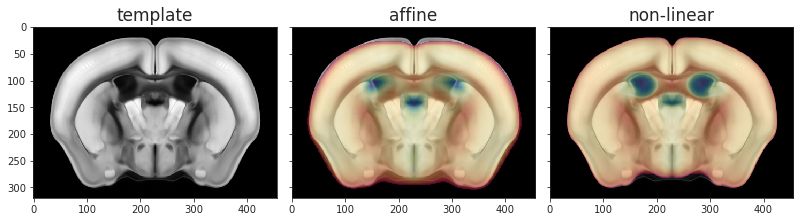

In [8]:
fig, axes = create_figure(1, 3, (11, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[240], cmap='Greys_r')
axes[1].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[2].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')

axes[0].set_title('template', fontsize=17)
axes[1].set_title('affine', fontsize=17)
axes[2].set_title('non-linear', fontsize=17)

fig.savefig(pjoin(fig_dir, 'transform.pdf'), **kws_fig)

plt.show()

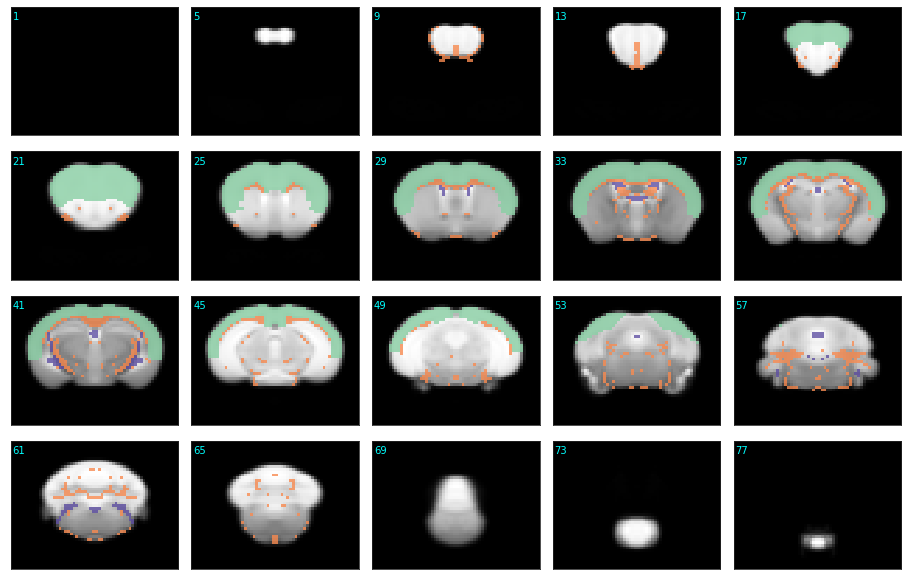

In [9]:
obj = _apply()
fig, axes = coronal()
fig.savefig(pjoin(fig_dir, 'coronal-N162.pdf'), **kws_fig)

In [10]:
for i_new, i in enumerate(np.unique(mask[mask.nonzero()])):
    mask[mask == i] = i_new + 1

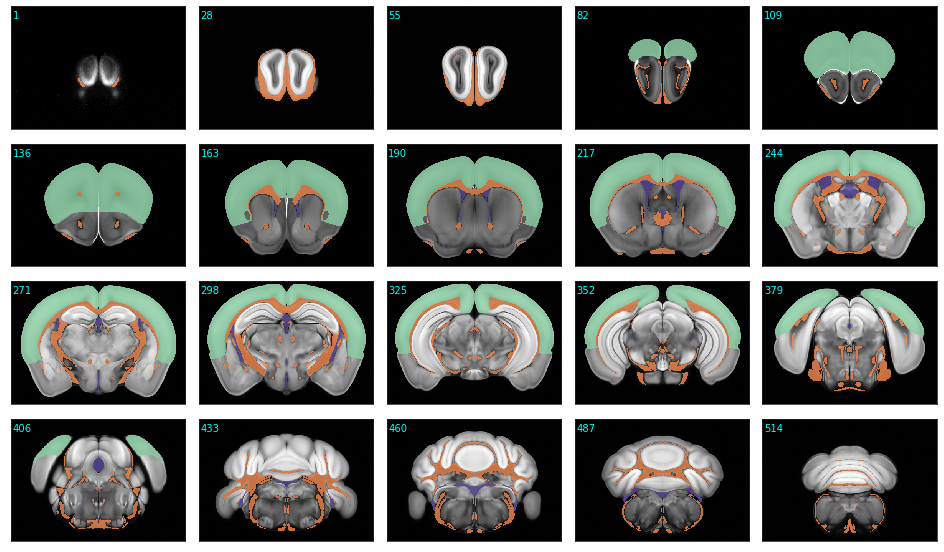

In [11]:
fig, axes = coronal_allen()
fig.savefig(pjoin(fig_dir, 'coronal-Allen.pdf'), **kws_fig)

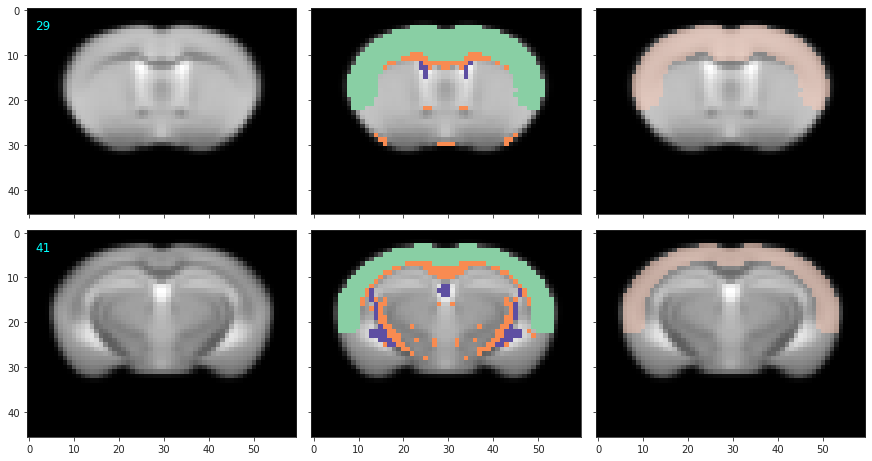

In [12]:
fig, axes = create_figure(2, 3, (12, 6.3), 'all', 'all', constrained_layout=True)
s_ = 29
axes[0, 0].annotate(
    text=s_,
    xy=(0.03, 0.9),
    fontsize=12,
    xycoords='axes fraction',
    color='cyan',
)
for ax in axes[0].flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[0, 1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')
axes[0, 2].imshow(mwh(obj[s_] != 2, obj[s_]), alpha=0.5, vmin=0, vmax=10, cmap='Reds')

s_ = 41
axes[1, 0].annotate(
    text=s_,
    xy=(0.03, 0.9),
    fontsize=12,
    xycoords='axes fraction',
    color='cyan',
)
for ax in axes[1].flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1, 1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')
axes[1, 2].imshow(mwh(obj[s_] != 2, obj[s_]), alpha=0.5, vmin=0, vmax=10, cmap='Reds')

fig.savefig(pjoin(fig_dir, 'compare.pdf'), **kws_fig)

plt.show()

## Erode

In [13]:
from register.parcellation import erode_repair

In [14]:
brain = 'Symmetric_N162_space-indiv3d_brain.nii.gz'
brain = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, brain),
    pixeltype='unsigned int',
)
brain.shape

(60, 46, 81)

In [15]:
eroded = erode_repair(brain.numpy())

In [16]:
img = reset_ants_img(
    img=eroded,
    spacing=brain.spacing,
    origin=brain.origin,
    dtype=brain.dtype,
    use_um=False,
)
name = 'Symmetric_N162_space-indiv3d_eroded.nii.gz'
ants.image_write(img, filename=pjoin(mice.cfg.masks_dir, name))

In [17]:
os.listdir(mice.cfg.masks_dir)

[
    'Symmetric_N162_space-indiv3d_brain.nii.gz',
    'Symmetric_N162_space-indiv3d_brain-eroded.nii.gz',
    'Symmetric_N162_space-indiv3d_iso.nii.gz',
    'Symmetric_N162_space-indiv3d_misc.nii.gz',
    'Symmetric_N162_space-indiv3d_hemis.nii.gz',
    'png',
    'Symmetric_N162_space-indiv3d_cols.nii.gz',
    'Symmetric_N162_space-indiv3d_eroded.nii.gz',
    'Symmetric_N162_space-indiv3d_cortex.nii.gz',
    'Symmetric_N162_space-indiv3d_subcortex.nii.gz'
]

In [18]:
missing = sorted(set(mice.parcel.df['id']) - set(unique_idxs(eroded)))
mice.parcel.df.loc[mice.parcel.df['id'].isin(missing)]

,id,acro,hemis,region,layer
257,258,Isocortex,1,2,2
361,362,Isocortex,1,106,2
641,642,Isocortex,2,2,2
745,746,Isocortex,2,106,2


In [19]:
brain = brain.numpy()

In [20]:
sizes_brain = unique_idxs(brain)
sizes_eroded = unique_idxs(eroded)
sizes_brain = {i: len(v) for i, v in sizes_brain.items()}
sizes_eroded = {i: len(v) for i, v in sizes_eroded.items()}

len(sizes_brain), len(sizes_eroded)

(2778, 2778)

In [21]:
df = []
df.append({
    'label': ['brain'] * len(sizes_brain),
    'size': sizes_brain.values(),
})
df.append({
    'label': ['eroded'] * len(sizes_brain),
    'size': sizes_eroded.values(),
})
df = pd.DataFrame(merge_dicts(df))

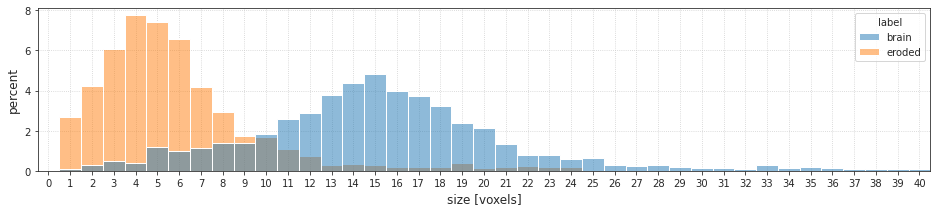

In [22]:
fig, ax = create_figure(figsize=(16, 3))
sns.histplot(
    data=df,
    x='size',
    hue='label',
    stat='percent',
    bins=np.linspace(0, 45, 46) - 0.5,
    legend=True,
    ax=ax,
)
ax.set_xlabel('size [voxels]', fontsize=12)
ax.set_ylabel('percent', fontsize=12)
ax.locator_params(axis='x', nbins=50)
ax.set_xlim(-0.5, 40.5)
ax.grid()
plt.show()

fig.savefig(pjoin(fig_dir, 'roi_sizes_eroded_N162.pdf'), **kws_fig)

### Plot eroded results

In [23]:
in_house = reg.load_in_house().numpy()

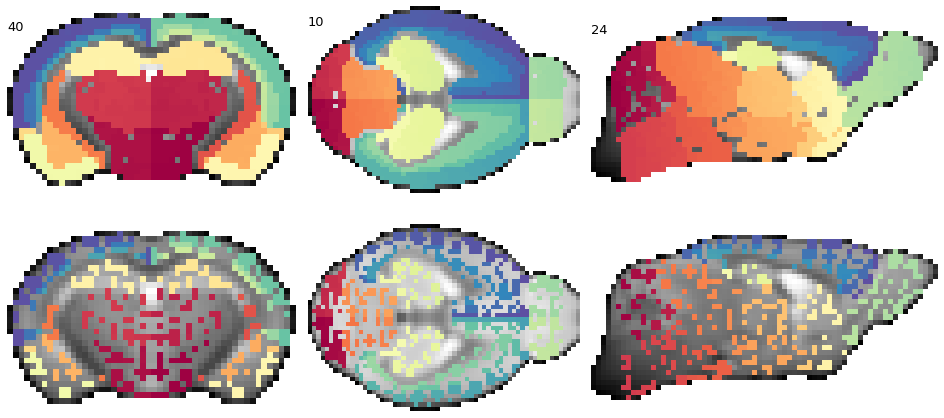

In [24]:
fig, axes = create_figure(2, 3, (13, 6), width_ratios=[1, 0.94, 1.2], constrained_layout=True)
for i, (axis, s_) in enumerate([(2, 40), (1, 10), (0, 24)]):
    axes[0, i].annotate(
        text=s_,
        xy=(0.0, 0.9),
        fontsize=13,
        xycoords='axes fraction',
        color='k',
    )
    data2p = filter_boundaries(
        x_list=[
            np.take(brain, s_, axis),
            np.take(eroded, s_, axis),
            np.take(in_house, s_, axis)],
        mask=np.take(in_house, s_, axis) > 2000,
    )
    if axis == 2:
        data2p = [e.T for e in data2p]
    for ax in axes[:, i].flat:
        ax.imshow(mwh(data2p[-1] < 2000, data2p[-1]), cmap='Greys_r')
    for j, x2p in enumerate(data2p[:-1]):
        axes[j, i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')

remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'eroded_N162.pdf'), **kws_fig)
plt.show()

In [25]:
root = mice.al.get_masks('root')
eroded = erode_repair(mice.parcel['brain'])

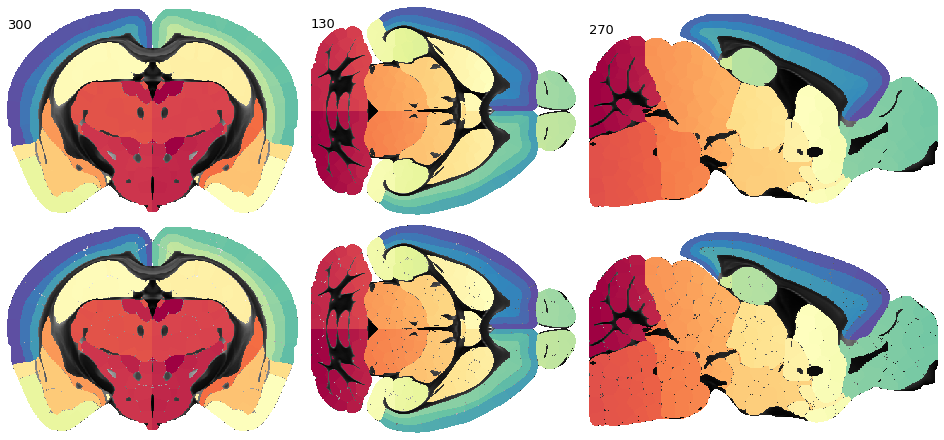

In [26]:
fig, axes = create_figure(2, 3, (13, 6), width_ratios=[1, 0.94, 1.2], constrained_layout=True)
for i, (axis, s_) in enumerate([(0, 300), (1, 130), (2, 270)]):
    axes[0, i].annotate(
        text=s_,
        xy=(0.0, 0.9),
        fontsize=13,
        xycoords='axes fraction',
        color='k',
    )
    data2p = filter_boundaries(
        x_list=[
            np.take(mice.parcel['brain'], s_, axis),
            np.take(eroded, s_, axis),
            np.take(mice.al.template, s_, axis),
            np.take(root, s_, axis),
        ], mask=np.take(root, s_, axis) > 0
    )
    if axis in [1, 2]:
        data2p = [e.T[:, ::-1] for e in data2p]
    for ax in axes[:, i].flat:
        ax.imshow(mwh(data2p[-1] <= 0, data2p[-2]), cmap='Greys_r')
    for j, x2p in enumerate(data2p[:-2]):
        axes[j, i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')

remove_ticks(axes)
fig.savefig(pjoin(fig_dir, 'eroded_Allen.pdf'), **kws_fig)
plt.show()

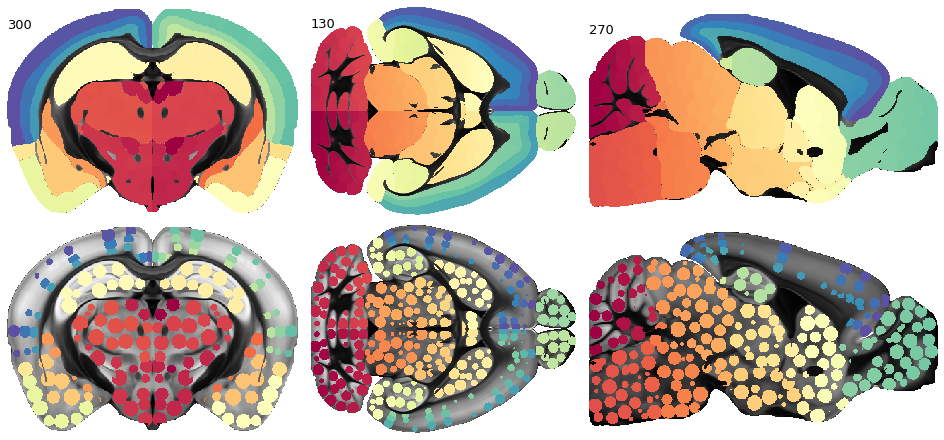

In [27]:
fig, axes = create_figure(2, 3, (13, 6), width_ratios=[1, 0.94, 1.2], constrained_layout=True)
for i, (axis, s_) in enumerate([(0, 300), (1, 130), (2, 270)]):
    axes[0, i].annotate(
        text=s_,
        xy=(0.0, 0.9),
        fontsize=13,
        xycoords='axes fraction',
        color='k',
    )
    data2p = filter_boundaries(
        x_list=[
            np.take(mice.parcel['brain'], s_, axis),
            np.take(mice.parcel['brain-eroded'], s_, axis),
            np.take(mice.al.template, s_, axis),
            np.take(root, s_, axis),
        ], mask=np.take(root, s_, axis) > 0
    )
    if axis in [1, 2]:
        data2p = [e.T[:, ::-1] for e in data2p]
    for ax in axes[:, i].flat:
        ax.imshow(mwh(data2p[-1] <= 0, data2p[-2]), cmap='Greys_r')
    for j, x2p in enumerate(data2p[:-2]):
        axes[j, i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')

remove_ticks(axes)
# fig.savefig(pjoin(fig_dir, 'eroded_Allen.pdf'), **kws_fig)
plt.show()